In [63]:
# based on clonealign framework, re-write with pyro
import logging
import sys

import os
from collections import defaultdict
import torch
import numpy as np
import pandas as pd
import scipy.stats
from torch.distributions import constraints
from torch.nn import Softplus
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.5.1')
pyro.enable_validation(True)

  8429951 Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [64]:
logging.basicConfig(format='%(relativeCreated) 9d %(message)s', level=logging.DEBUG)

# Add another handler for logging debugging events (e.g. for profiling)
# in a separate stream that can be captured.
log = logging.getLogger()
debug_handler = logging.StreamHandler(sys.stdout)
debug_handler.setLevel(logging.DEBUG)
debug_handler.addFilter(filter=lambda record: record.levelno <= logging.DEBUG)
log.addHandler(debug_handler)

In [65]:
# input data

expr_input = "data/SPECTRUM-OV-022_expr_clonealign_input.csv"
cnv_input = "data/SPECTRUM-OV-022_cnv_clonealign_input.csv"

clone_assign_prob_output = "data/SPECTRUM-OV-022_clone_assign_prob_0.csv"
gene_type_score_output = "data/SPECTRUM-OV-022_gene_type_score_0.csv"



In [66]:

expr_csv = pd.read_csv(expr_input, header = 0, index_col=0)
cnv_csv = pd.read_csv(cnv_input, header = 0, index_col=0)

expr_csv = expr_csv[expr_csv.mean(1) > 0]
cnv_csv = cnv_csv.loc[expr_csv.index, ]

# cast cnv greater than 6
cnv = torch.tensor(cnv_csv.values, dtype=torch.float)
cnv = torch.transpose(cnv, 0, 1)

cnv[cnv > 6] = 6

expr = torch.tensor(expr_csv.values, dtype = torch.float)
expr = torch.transpose(expr, 0, 1)



In [67]:
# input data: cnv, expr
# cnv: clone_count * gene_count
# expr: cell_count * gene_count
def inverse_softplus(x):
    return x + torch.log(-torch.expm1(-x))

@config_enumerate
def clonealign_pyro(cnv, expr, temperature):
    num_of_clones = len(cnv)
    num_of_cells = len(expr)
    num_of_genes = len(expr[0])

    softplus = Softplus()

    # initialize per_copy_expr using the data (This typically speeds up convergence)
    expr = expr * 2000 / torch.reshape(torch.sum(expr, 1), (num_of_cells, 1))
    per_copy_expr_guess = torch.mean(expr, 0)

    # calculate copy number mean
    copy_number_mean = torch.mean(cnv, 0)

    # draw chi from gamma
    chi = pyro.sample('expose_chi', dist.Gamma(torch.ones(6) * 2, torch.ones(6)).to_event(1))

    with pyro.plate('gene', num_of_genes):
        # draw per_copy_expr from softplus-transformed Normal distribution
        per_copy_expr = pyro.sample('expose_per_copy_expr',
                                    dist.Normal(inverse_softplus(per_copy_expr_guess), torch.ones(num_of_genes)))
        

        per_copy_expr = softplus(per_copy_expr)
        
        # instead of softplus-transformed normal, use negative binomial instead for per_copy_expr
        # per_copy_expr = pyro.sample('per_copy_expr', dist.NegativeBinomial())

        # draw w from Normal
        w = pyro.sample('expose_w', dist.Normal(torch.zeros(6), torch.sqrt(chi)).to_event(1))

        # sample the gene_type_score from uniform distribution.
        # the score reflects how much the copy number influence expression.
        gene_type_score = pyro.sample('expose_gene_type_score', dist.Dirichlet(torch.ones(2)))
        gene_type = pyro.sample('expose_gene_type', dist.RelaxedOneHotCategorical(temperature = torch.tensor([0.5]), probs = gene_type_score))

    with pyro.plate('cell', num_of_cells):
        # draw clone_assign_prob from Dir
        clone_assign_prob = pyro.sample('expose_clone_assign_prob', dist.Dirichlet(torch.ones(num_of_clones) * 0.1))
        # draw clone_assign from Cat
        clone_assign = pyro.sample('clone_assign', dist.Categorical(clone_assign_prob))

        # draw psi from Normal
        psi = pyro.sample('expose_psi', dist.Normal(torch.zeros(6), torch.ones(6)).to_event(1))        

        expected_expr = per_copy_expr * (
                    Vindex(cnv)[clone_assign] * gene_type[:, 0] + copy_number_mean * gene_type[:, 1]) * torch.exp(
            torch.matmul(psi, torch.transpose(w, 0, 1)))

        # draw expr from Multinomial
        pyro.sample('obs', dist.Multinomial(total_count = 2000, probs=expected_expr, validate_args=False), obs=expr)
        


In [68]:
# initialize Adam optimizer
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})

# TraceEnum_ELBO will marginalize out the assignments of datapoints to clusters
elbo = TraceEnum_ELBO(max_plate_nesting=2)

pyro.clear_param_store()

# AutoGuide
global_guide = AutoDelta(poutine.block(clonealign_pyro, expose_fn=lambda msg: msg["name"].startswith("expose_")))
# put together SVI object
svi = SVI(clonealign_pyro, global_guide, optim, loss=elbo)

In [70]:
tau0 = 1.0
ANNEAL_RATE=0.0003
MIN_TEMP=0.5
np_temp=tau0


gradient_norms = defaultdict(list)
svi.loss(clonealign_pyro, global_guide, cnv, expr, np_temp)  # Initializes param store.

12573142.0

In [72]:
losses = []
max_iter = 500
rel_tol = 1e-5
print('Start Inference.')
for i in range(max_iter if not smoke_test else 2):
    loss = svi.step(cnv, expr, np_temp)
    if i % 100 == 1:
        np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
    
    if i >= 1:
        loss_diff = abs((losses[-1] - loss)/losses[-1])
        if loss_diff < rel_tol:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    
    print('.' if i % 500 else '\n', end='')

Start Inference.

................................................................................................................................................................................................................ELBO converged at iteration 209


In [40]:
losses

[]

 10376878 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10376881 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10376895 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10376898 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10376904 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10376908 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


 10377024 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377025 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377029 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377032 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377034 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377037 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


 10377053 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377055 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377058 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377060 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377064 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377066 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


 10377075 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377078 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377081 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377083 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377086 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377088 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


 10377109 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377111 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377114 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377118 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377120 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377123 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


 10377129 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377131 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377133 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377134 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377138 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377140 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


 10377156 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377158 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377162 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377165 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377168 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377170 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


 10377177 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377179 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377183 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377184 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377187 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377188 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


 10377216 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377218 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377221 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377224 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377228 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377231 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


 10377315 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377318 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377323 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377326 ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])


 10377327 vmin 9596972.360151106 vmax 12735910.27474622


vmin 9596972.360151106 vmax 12735910.27474622
vmin 9596972.360151106 vmax 12735910.27474622


 10377329 ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


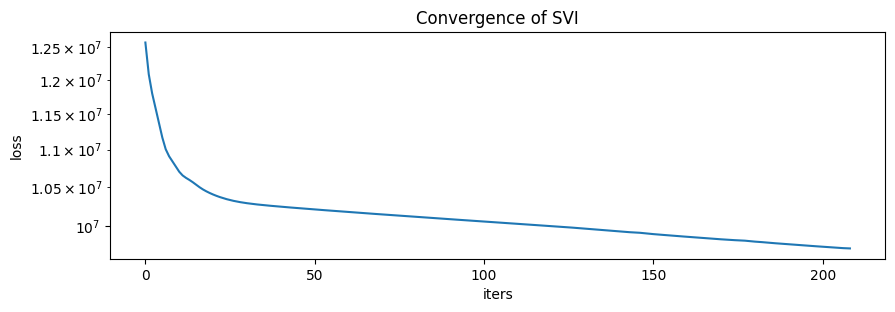

In [73]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
_ = pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [74]:
map_estimates = global_guide(cnv, expr)

clone_assign_prob = map_estimates['expose_clone_assign_prob']
gene_type_score = map_estimates['expose_gene_type_score']

per_copy_expr = map_estimates['expose_per_copy_expr']
psi = map_estimates['expose_psi']
chi = map_estimates['expose_chi']
w = map_estimates['expose_w']

clone_assign_prob_dataframe = pd.DataFrame(clone_assign_prob.data.numpy())
gene_type_score_dataframe = pd.DataFrame(gene_type_score.data.numpy())

In [75]:
rowname_dict = {i:c for i, c in enumerate(expr_csv.columns)}
colname_dict = {i:c for i, c in enumerate(cnv_csv.columns)}

genename_dict = {i:c for i, c in enumerate(expr_csv.index)}

clone_assign_prob_dataframe.rename(index = rowname_dict, inplace = True)
clone_assign_prob_dataframe.rename(columns = colname_dict, inplace = True)

gene_type_score_dataframe.rename(index = genename_dict, inplace = True)

In [76]:
clone_assign_prob_dataframe.to_csv(clone_assign_prob_output)

In [77]:
gene_type_score_dataframe.to_csv(gene_type_score_output)

In [78]:
clone_assign_prob_dataframe

,cluster_1,cluster_2,cluster_3
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACCCACAAGCGCAA,8.852903e-20,8.852903e-20,1.000000e+00
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACCCATCGCGGACT,1.000000e+00,8.852903e-20,8.852903e-20
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGAATCCTTGGAA,1.000000e+00,8.852869e-20,8.852869e-20
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGCTCACTATCGA,1.000000e+00,8.852903e-20,8.852903e-20
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGCTGTCGACTTA,1.000000e+00,8.852903e-20,8.852903e-20
...,...,...,...
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGATCCATGACTGT,8.852903e-20,8.852903e-20,1.000000e+00
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGATCGTTCAAGTC,8.852903e-20,8.852903e-20,1.000000e+00
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGGAGTCCATTGCC,8.852869e-20,8.852869e-20,1.000000e+00
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGTTGGTGTCTAAC,8.852869e-20,1.000000e+00,8.852869e-20


In [76]:
clone_assign_prob_dataframe

,clone1,clone2,clone3,clone4
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACCCACAAGCGCAA,0.001993,0.001993,0.001993,0.994020
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACCCATCGCGGACT,0.994020,0.001993,0.001993,0.001993
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACGAATCCTTGGAA,0.984887,0.008323,0.001852,0.004938
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACGCTCACTATCGA,0.994020,0.001993,0.001993,0.001993
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACGCTGTCGACTTA,0.994020,0.001993,0.001993,0.001993
...,...,...,...,...
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGATCGTTCAAGTC,0.001993,0.001993,0.001993,0.994020
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGGAGGTGTGTGTT,0.002184,0.001989,0.993905,0.001921
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGGAGTCCATTGCC,0.001996,0.002081,0.002011,0.993913
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGTTGGTGTCTAAC,0.001983,0.001992,0.994061,0.001964
